In [1]:
%matplotlib inline
import pandas as pd 
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import LSTM_CNN as lx

In [2]:
input_file = 'data/chilectra.csv'
df = pd.read_csv(input_file)

In [3]:
input_train, output_train, input_test, output_test, mean, std = lx.get_train_test(df["load"], 168, 24, 8760)

In [4]:
model = lx.build_model(168, 24)

In [5]:
model = lx.train_model(input_train, output_train, epochs=2, train=False)

In [6]:
pred = lx.model_predict(model, input_test, mean, std)

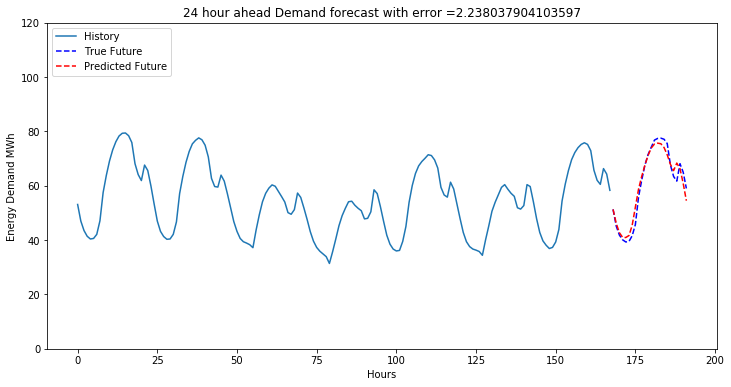

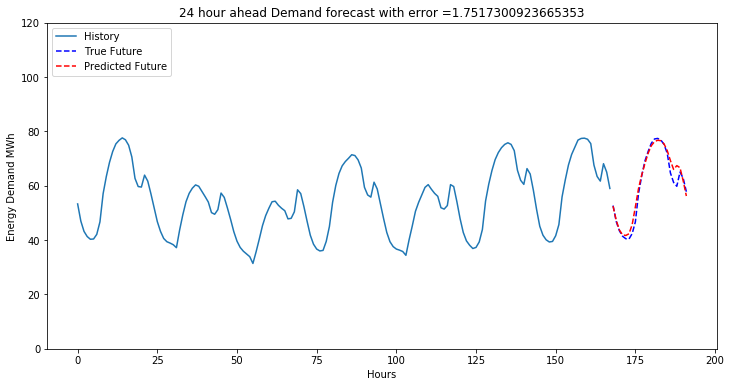

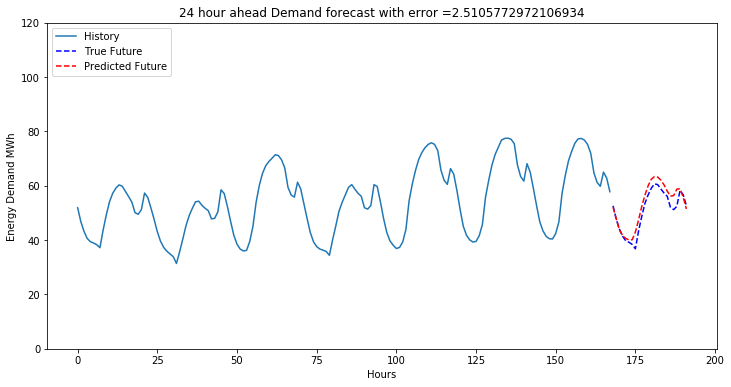

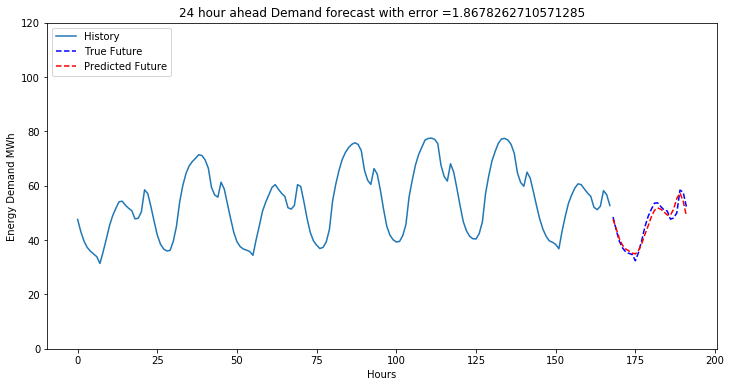

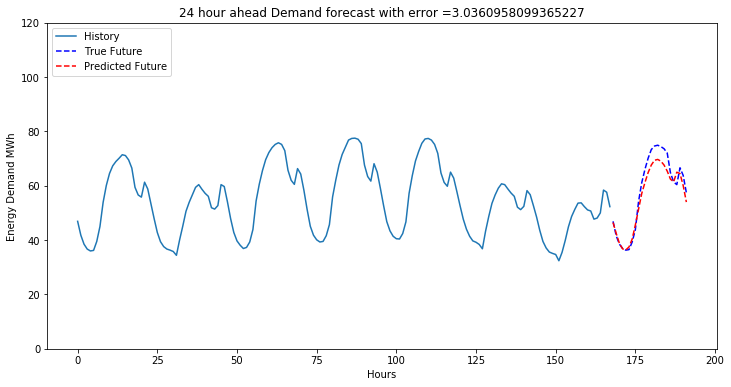

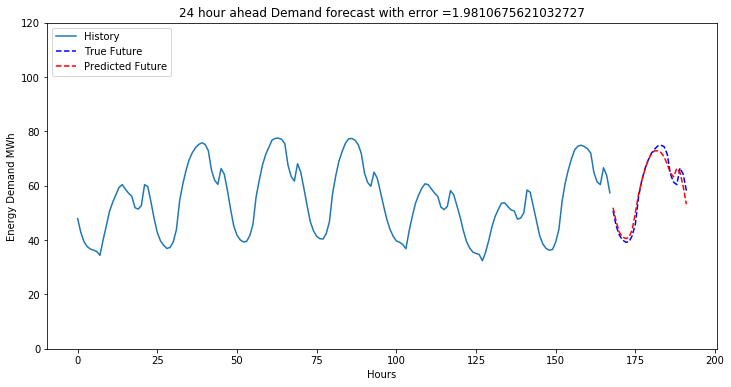

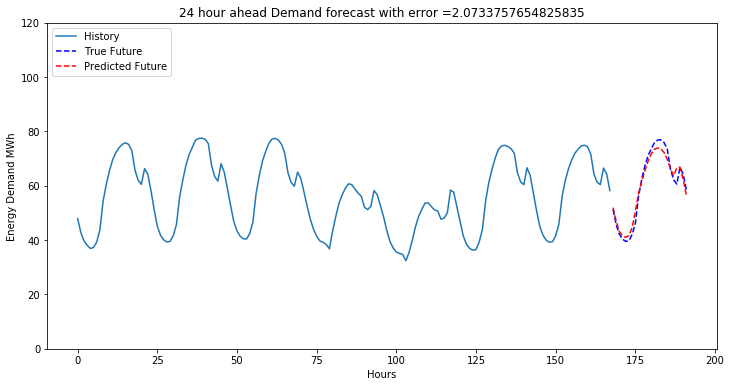

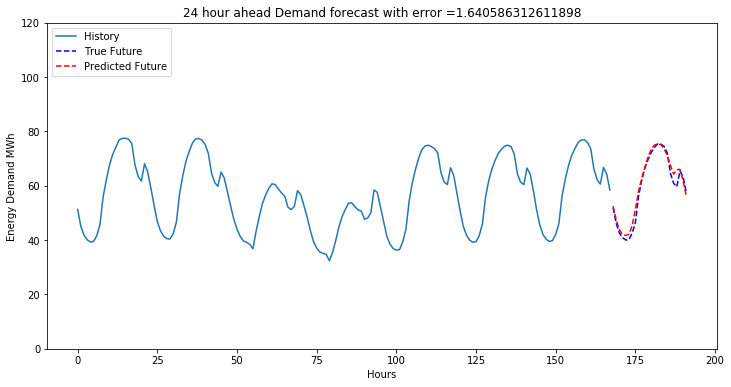

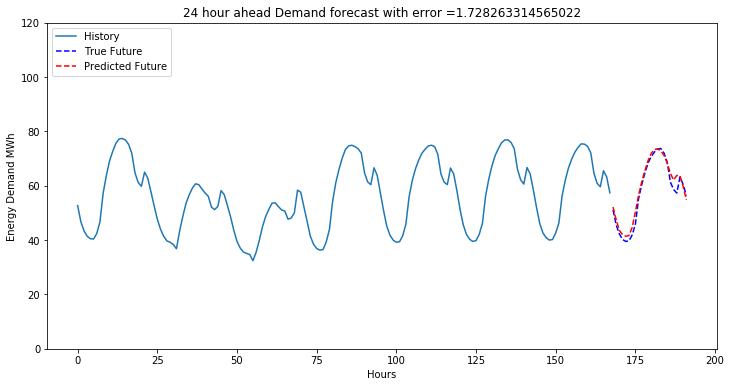

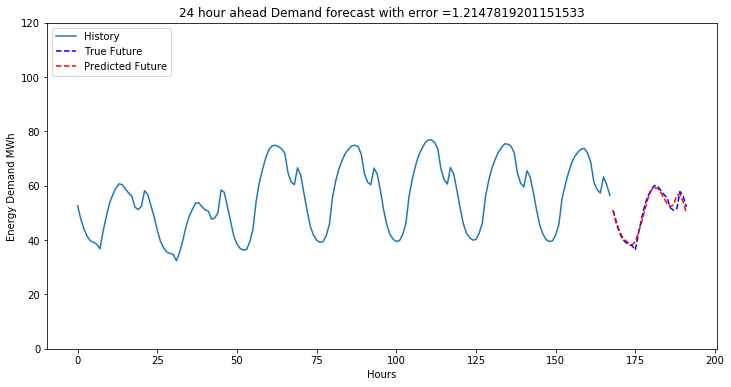

In [7]:
from plot_results import multi_step_plot
for i in range(10,20):
    plt = multi_step_plot(input_test[24*i]*std+mean, output_test[24*i]*std+mean, pred[24*i])
    plt.show()